In [ ]:
import cv2
import numpy as np
import pandas as pd
from deepface import DeepFace
import os

# --- CONFIGURATION ---
INVENTORY_CSV = "video_inventory.csv" # The file with cam_path, screen_path, id
OUTPUT_CSV = "training_features.csv"
SAMPLE_RATE = 15  # Process 1 frame every 15 frames (approx 2 times per second)
# ---------------------

def extract_features(cam_path, screen_path, label):
    # 1. Setup
    cap_cam = cv2.VideoCapture(cam_path)
    cap_scr = cv2.VideoCapture(screen_path)
    
    # We will average features over the whole video to create a "Video Signature"
    # Or we can keep time-series data. For 100 videos, a "Signature" is safer to avoid overfitting.
    
    emotions_sum = {'angry': 0, 'disgust': 0, 'fear': 0, 'happy': 0, 'sad': 0, 'surprise': 0, 'neutral': 0}
    screen_motion_sum = 0
    frame_count = 0
    valid_frames = 0
    
    prev_gray_scr = None
    
    while True:
        ret_c, frame_c = cap_cam.read()
        ret_s, frame_s = cap_scr.read()
        
        if not ret_c or not ret_s: break
        
        # Process every Nth frame
        if frame_count % SAMPLE_RATE == 0:
            try:
                # A. FACE ANALYSIS
                # We use the raw probability scores, not just the label
                result = DeepFace.analyze(frame_c, actions=['emotion'], 
                                        enforce_detection=False, silent=True)
                
                if result:
                    probs = result[0]['emotion'] # Returns dict {'angry': 0.02, 'happy': 99.0...}
                    for key in emotions_sum:
                        emotions_sum[key] += probs.get(key, 0)
                    
                # B. SCREEN ANALYSIS (Optical Flow / Commotion)
                gray_s = cv2.cvtColor(frame_s, cv2.COLOR_BGR2GRAY)
                gray_s = cv2.resize(gray_s, (224, 224)) # Resize for speed
                
                if prev_gray_scr is not None:
                    diff = cv2.absdiff(prev_gray_scr, gray_s)
                    score = np.sum(diff) / (224*224) # Normalize by size
                    screen_motion_sum += score
                
                prev_gray_scr = gray_s
                valid_frames += 1
                
            except Exception as e:
                pass
        
        frame_count += 1
        
    cap_cam.release()
    cap_scr.release()
    
    if valid_frames == 0: return None
    
    # C. Normalize (Get Averages)
    features = {}
    for key, val in emotions_sum.items():
        features[f"face_{key}"] = val / valid_frames
        
    features['screen_motion'] = screen_motion_sum / valid_frames
    features['label'] = label
    
    return features

# --- MAIN LOOP ---
print("Extracting Features for Custom Training...")
df = pd.read_csv(INVENTORY_CSV)

# Load labels if you have them (from your auto-labeling earlier)
labels_df = pd.read_csv("labeled_dataset.csv") 
# We merge them to make sure we have the 'label' column
df = df.merge(labels_df[['id', 'label']], on='id', how='left')

all_data = []

for index, row in df.iterrows():
    print(f"Processing ID {row['id']}...", end="")
    
    if pd.isna(row['label']):
        print(" -> SKIP (No Label)")
        continue
        
    feats = extract_features(row['cam_path'], row['screen_path'], row['label'])
    
    if feats:
        feats['id'] = row['id']
        all_data.append(feats)
        print(" -> Done")
    else:
        print(" -> Failed (Video Error)")

# Save
train_df = pd.DataFrame(all_data)
train_df.to_csv(OUTPUT_CSV, index=False)
print("-" * 30)
print(f"Feature Extraction Complete. Saved to {OUTPUT_CSV}")
print(train_df.head())

In [3]:
%pip install seaborn

     -------------------------------------- 294.9/294.9 kB 1.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


--- Custom Model Results ---
              precision    recall  f1-score   support

        PASS       0.88      0.70      0.78        10
        FAIL       0.77      0.91      0.83        11

    accuracy                           0.81        21
   macro avg       0.82      0.80      0.81        21
weighted avg       0.82      0.81      0.81        21



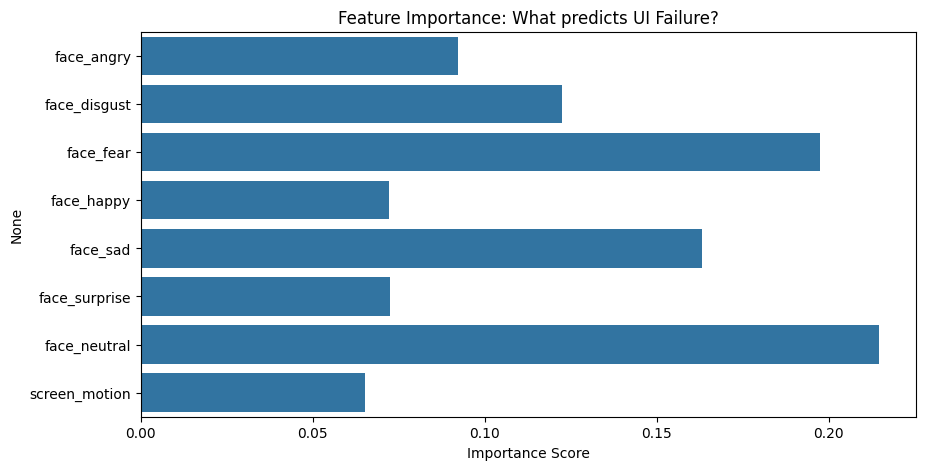

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Load Data
df = pd.read_csv("training_features.csv")

# 2. Prepare Features (X) and Labels (y)
# We drop ID and Label from inputs
X = df.drop(columns=['id', 'label'])
y = df['label']

# 3. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train Custom Model
# Random Forest is excellent for small datasets (100 rows) with complex features
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Evaluate
y_pred = model.predict(X_test)

print("--- Custom Model Results ---")
print(classification_report(y_test, y_pred, target_names=['PASS', 'FAIL']))

# 6. Novelty Visualization: Which features matter most?
# This proves your thesis: "Which emotions predict failure in Sri Lankan users?"
import numpy as np
feature_importance = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance, y=feature_names)
plt.title("Feature Importance: What predicts UI Failure?")
plt.xlabel("Importance Score")
plt.show()

In [6]:
import pandas as pd
import numpy as np
import cv2
from deepface import DeepFace

# --- CONFIGURATION ---
TEST_CAM = "dataset/cam72.mkv"      # <--- Change to a test video
TEST_SCREEN = "dataset/screen72.mkv"
# ---------------------

def predict_ui_quality(cam_path, screen_path, model):
    print(f"Analyzing Video Pair...")
    
    # 1. Extract Features (Same logic as training)
    cap_cam = cv2.VideoCapture(cam_path)
    cap_scr = cv2.VideoCapture(screen_path)
    
    emotions_sum = {'angry': 0, 'disgust': 0, 'fear': 0, 'happy': 0, 'sad': 0, 'surprise': 0, 'neutral': 0}
    screen_motion_sum = 0
    valid_frames = 0
    frame_count = 0
    prev_gray_scr = None
    
    while True:
        ret_c, frame_c = cap_cam.read()
        ret_s, frame_s = cap_scr.read()
        if not ret_c or not ret_s: break
        
        # Sample every 15 frames (approx 0.5 sec)
        if frame_count % 15 == 0:
            try:
                # Face
                result = DeepFace.analyze(frame_c, actions=['emotion'], enforce_detection=False, silent=True)
                if result:
                    probs = result[0]['emotion']
                    for key in emotions_sum:
                        emotions_sum[key] += probs.get(key, 0)
                
                # Screen
                gray_s = cv2.cvtColor(frame_s, cv2.COLOR_BGR2GRAY)
                gray_s = cv2.resize(gray_s, (224, 224))
                if prev_gray_scr is not None:
                    diff = cv2.absdiff(prev_gray_scr, gray_s)
                    score = np.sum(diff) / (224*224)
                    screen_motion_sum += score
                prev_gray_scr = gray_s
                valid_frames += 1
            except: pass
        frame_count += 1
        
    cap_cam.release()
    cap_scr.release()
    
    if valid_frames == 0: return "Error processing video"

    # 2. Normalize Features
    features = {}
    for key, val in emotions_sum.items():
        features[f"face_{key}"] = val / valid_frames
    features['screen_motion'] = screen_motion_sum / valid_frames
    
    # Create DataFrame for Model
    input_df = pd.DataFrame([features])
    
    # Reorder columns to match training data exactly
    # (We rely on the feature names from the trained model)
    input_df = input_df[model.feature_names_in_]
    
    # 3. Predict
    prediction = model.predict(input_df)[0]
    probabilities = model.predict_proba(input_df)[0]
    
    # 4. Generate the "Why?" Explanation
    result_text = "PASS (Good UI)" if prediction == 0 else "FAIL (Buggy UI)"
    confidence = max(probabilities) * 100
    
    # Find the strongest emotion
    dominant_emotion = max(emotions_sum, key=emotions_sum.get)
    
    print("-" * 40)
    print(f"🤖 AI Verdict:  {result_text}")
    print(f"📊 Confidence: {confidence:.1f}%")
    print("-" * 40)
    print("📝 Diagnostics:")
    print(f"   • Dominant Emotion: {dominant_emotion.upper()}")
    print(f"   • Screen Activity:  {features['screen_motion']:.2f} (Motion Score)")
    
    if prediction == 1:
        print("\n🚩 Root Cause Analysis:")
        if dominant_emotion == 'fear':
            print("   User showed signs of ANXIETY/CONFUSION. The UI likely lacks clear instructions.")
        elif dominant_emotion == 'sad':
            print("   User showed signs of DISAPPOINTMENT. The UI likely failed to meet expectations.")
        elif dominant_emotion == 'angry':
            print("   User showed signs of FRUSTRATION. The UI likely has unresponsive elements.")
        else:
            print(f"   User reaction ({dominant_emotion}) deviates from the neutral baseline.")

# Run the Demo
predict_ui_quality(TEST_CAM, TEST_SCREEN, model)

Analyzing Video Pair...
----------------------------------------
🤖 AI Verdict:  FAIL (Buggy UI)
📊 Confidence: 92.0%
----------------------------------------
📝 Diagnostics:
   • Dominant Emotion: NEUTRAL
   • Screen Activity:  6.84 (Motion Score)

🚩 Root Cause Analysis:
   User reaction (neutral) deviates from the neutral baseline.


In [2]:
import cv2
import pandas as pd
from deepface import DeepFace
from ultralytics import YOLO
import datetime

# --- CONFIGURATION ---
CAM_VIDEO = "dataset/cam47.mkv"       # User Face
SCREEN_VIDEO = "dataset/screen47.mkv" # Screen Recording
YOLO_MODEL = "best.pt"                # Your trained UI detector
OUTPUT_REPORT = "bug_report.csv"
# ---------------------

def format_time(seconds):
    return str(datetime.timedelta(seconds=int(seconds)))

def forensic_analysis(cam_path, screen_path, yolo_path):
    print(f"Loading YOLO from {yolo_path}...")
    try:
        yolo = YOLO(yolo_path)
    except:
        print("Error: Could not load YOLO model. Check path.")
        return

    cap_cam = cv2.VideoCapture(cam_path)
    cap_scr = cv2.VideoCapture(screen_path)
    
    fps = cap_cam.get(cv2.CAP_PROP_FPS)
    if fps == 0: fps = 30
    
    # We only care about "Bad" emotions
    triggers = ['angry', 'disgust', 'fear', 'sad']
    
    print("-" * 60)
    print(f"{'TIME':<10} | {'EMOTION':<12} | {'DETECTED UI ELEMENT'}")
    print("-" * 60)
    
    bug_log = []
    frame_count = 0
    
    while True:
        # Check 1 frame every second (to be fast)
        frames_to_skip = int(fps) 
        cap_cam.set(cv2.CAP_PROP_POS_FRAMES, frame_count)
        
        ret_c, frame_c = cap_cam.read()
        if not ret_c: break
        
        current_time = frame_count / fps
        
        try:
            # 1. Check Face
            result = DeepFace.analyze(frame_c, actions=['emotion'], 
                                    enforce_detection=False, silent=True)
            
            if result:
                emotion = result[0]['dominant_emotion']
                
                # 2. If Bad Emotion Detected -> Check Screen
                if emotion in triggers:
                    # Sync Screen Video
                    cap_scr.set(cv2.CAP_PROP_POS_MSEC, current_time * 1000)
                    ret_s, frame_s = cap_scr.read()
                    
                    if ret_s:
                        # 3. Run YOLO on this specific screen frame
                        yolo_results = yolo(frame_s, verbose=False)
                        
                        detected_ui = "Unknown UI Area"
                        
                        # Get the UI element with highest confidence
                        for r in yolo_results:
                            if len(r.boxes) > 0:
                                # Just pick the first/most confident box
                                cls_id = int(r.boxes.cls[0])
                                detected_ui = yolo.names[cls_id]
                                break
                        
                        # Print Log
                        timestamp = format_time(current_time)
                        print(f"{timestamp:<10} | {emotion:<12} | {detected_ui}")
                        
                        bug_log.append({
                            "timestamp": timestamp,
                            "emotion": emotion,
                            "ui_element": detected_ui
                        })
                        
        except Exception as e:
            pass
            
        frame_count += frames_to_skip

    cap_cam.release()
    cap_scr.release()
    
    # Save to CSV
    if bug_log:
        pd.DataFrame(bug_log).to_csv(OUTPUT_REPORT, index=False)
        print("-" * 60)
        print(f"Forensic Report Saved to {OUTPUT_REPORT}")
    else:
        print("No frustration detected.")

# Run it
forensic_analysis(CAM_VIDEO, SCREEN_VIDEO, YOLO_MODEL)

Loading YOLO from best.pt...
------------------------------------------------------------
TIME       | EMOTION      | DETECTED UI ELEMENT
------------------------------------------------------------
0:00:06    | sad          | image
0:00:08    | fear         | button
0:00:10    | fear         | button
0:00:12    | fear         | button
0:00:15    | fear         | image
0:00:16    | fear         | image
0:00:17    | fear         | button
0:00:18    | fear         | image
0:00:19    | fear         | image
0:00:20    | fear         | image
0:00:21    | fear         | image
0:00:22    | fear         | button
0:00:23    | fear         | image
0:00:24    | fear         | image
0:00:25    | fear         | image
0:00:26    | fear         | button
0:00:27    | fear         | image
0:00:28    | fear         | image
0:00:29    | fear         | image
0:00:30    | fear         | image
0:00:31    | fear         | button
0:00:32    | fear         | button
0:00:34    | sad          | image
0:00:52    

In [2]:
import cv2
import pandas as pd
from deepface import DeepFace
from ultralytics import YOLO
import numpy as np

# --- CONFIGURATION ---
CAM_VIDEO = "dataset/cam5.mp4"       
SCREEN_VIDEO = "dataset/screen5.mp4" 
YOLO_MODEL = "best.pt"                
OUTPUT_VIDEO = "final_forensic_evidence3.mp4"
# ---------------------

def create_forensic_video(cam_path, screen_path, yolo_path, output_path):
    print(f"Loading YOLO from {yolo_path}...")
    try:
        yolo = YOLO(yolo_path)
    except:
        print("Error: Check YOLO path.")
        return

    cap_cam = cv2.VideoCapture(cam_path)
    cap_scr = cv2.VideoCapture(screen_path)
    
    # Get Screen Video Properties
    width = int(cap_scr.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_scr.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap_scr.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap_scr.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Setup Video Writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Triggers for "Bad UI"
    triggers = ['angry', 'disgust', 'fear', 'sad']
    
    print(f"Generating Video ({total_frames} frames)... This may take a moment.")
    
    current_emotion = "neutral"
    current_ui_box = None
    current_ui_label = ""
    
    frame_idx = 0
    
    while True:
        ret_s, frame_scr = cap_scr.read()
        if not ret_s: break
        
        # We need to sync the webcam (cam might have different FPS, so we map by time)
        current_time_ms = cap_scr.get(cv2.CAP_PROP_POS_MSEC)
        cap_cam.set(cv2.CAP_PROP_POS_MSEC, current_time_ms)
        ret_c, frame_cam = cap_cam.read()
        
        # OPTIMIZATION: Check emotion only once every 15 frames (0.5 seconds)
        # We hold the emotion/box state constant in between checks to make the video smooth.
        if frame_idx % 15 == 0 and ret_c:
            try:
                result = DeepFace.analyze(frame_cam, actions=['emotion'], 
                                        enforce_detection=False, silent=True)
                if result:
                    current_emotion = result[0]['dominant_emotion']
                    
                    # If Bad Emotion -> Find the Culprit on Screen
                    if current_emotion in triggers:
                        # Run YOLO on this screen frame
                        results = yolo(frame_scr, verbose=False)
                        
                        # Reset box
                        current_ui_box = None
                        current_ui_label = ""
                        
                        # Pick the most confident detection
                        for r in results:
                            if len(r.boxes) > 0:
                                box = r.boxes[0] # Top 1
                                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                                cls_id = int(box.cls[0])
                                
                                current_ui_box = (int(x1), int(y1), int(x2), int(y2))
                                current_ui_label = yolo.names[cls_id]
                                break
                    else:
                        current_ui_box = None # Clear box if user is happy/neutral
            except:
                pass

        # --- DRAWING ON FRAME ---
        
        # If we have a detected failure case active
        if current_ui_box is not None:
            # 1. Draw Red Box around the UI element
            x1, y1, x2, y2 = current_ui_box
            cv2.rectangle(frame_scr, (x1, y1), (x2, y2), (0, 0, 255), 4)
            
            # 2. Draw "Error Header"
            # Semi-transparent bar at the top
            overlay = frame_scr.copy()
            cv2.rectangle(overlay, (0, 0), (width, 80), (0, 0, 255), -1)
            frame_scr = cv2.addWeighted(overlay, 0.3, frame_scr, 0.7, 0)
            
            # 3. Add Text: "USER FEAR: FIX BUTTON"
            text = f"USER {current_emotion.upper()}: FIX {current_ui_label.upper()}"
            cv2.putText(frame_scr, text, (20, 50), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 3)
            
            # 4. Add Label near the box
            cv2.putText(frame_scr, "BUG SOURCE", (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
            
        else:
            # Optional: Show "Pass" status slightly
            cv2.putText(frame_scr, f"User Status: {current_emotion}", (20, 40), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        out.write(frame_scr)
        frame_idx += 1
        
        if frame_idx % 100 == 0:
            print(f"Processed {frame_idx}/{total_frames} frames...")

    cap_cam.release()
    cap_scr.release()
    out.release()
    print("-" * 50)
    print(f"DONE! Video saved to: {output_path}")

# Run it
create_forensic_video(CAM_VIDEO, SCREEN_VIDEO, YOLO_MODEL, OUTPUT_VIDEO)

Loading YOLO from best.pt...
Generating Video (8889 frames)... This may take a moment.
Processed 100/8889 frames...
Processed 200/8889 frames...
Processed 300/8889 frames...
Processed 400/8889 frames...
Processed 500/8889 frames...
Processed 600/8889 frames...
Processed 700/8889 frames...
Processed 800/8889 frames...
Processed 900/8889 frames...
Processed 1000/8889 frames...
Processed 1100/8889 frames...
Processed 1200/8889 frames...
Processed 1300/8889 frames...
Processed 1400/8889 frames...
Processed 1500/8889 frames...
Processed 1600/8889 frames...
Processed 1700/8889 frames...
Processed 1800/8889 frames...
Processed 1900/8889 frames...
Processed 2000/8889 frames...
Processed 2100/8889 frames...
Processed 2200/8889 frames...
Processed 2300/8889 frames...
Processed 2400/8889 frames...
Processed 2500/8889 frames...
Processed 2600/8889 frames...
Processed 2700/8889 frames...
Processed 2800/8889 frames...
Processed 2900/8889 frames...
Processed 3000/8889 frames...
Processed 3100/8889 fr

In [1]:
import cv2
import pandas as pd
from deepface import DeepFace
from ultralytics import YOLO
import numpy as np
import json  # <--- Added for JSON support

# --- CONFIGURATION ---
CAM_VIDEO = "dataset/cam5.mkv"       
SCREEN_VIDEO = "dataset/screen5.mkv" 
YOLO_MODEL = "best.pt"                
OUTPUT_VIDEO = "final_forensic_evidence1.mp4"
OUTPUT_JSON = "forensic_report1.json" # <--- New output file
# ---------------------

def create_forensic_video(cam_path, screen_path, yolo_path, output_path, json_path):
    print(f"Loading YOLO from {yolo_path}...")
    try:
        yolo = YOLO(yolo_path)
    except:
        print("Error: Check YOLO path.")
        return

    cap_cam = cv2.VideoCapture(cam_path)
    cap_scr = cv2.VideoCapture(screen_path)
    
    width = int(cap_scr.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_scr.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap_scr.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap_scr.get(cv2.CAP_PROP_FRAME_COUNT))
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    triggers = ['angry', 'disgust', 'fear', 'sad']
    
    # --- JSON TRACKING ---
    timeline_data = [] # List to store every flagged event
    
    print(f"Generating Video ({total_frames} frames)... This may take a moment.")
    
    current_emotion = "neutral"
    current_ui_box = None
    current_ui_label = ""
    frame_idx = 0
    
    while True:
        ret_s, frame_scr = cap_scr.read()
        if not ret_s: break
        
        current_time_ms = cap_scr.get(cv2.CAP_PROP_POS_MSEC)
        cap_cam.set(cv2.CAP_PROP_POS_MSEC, current_time_ms)
        ret_c, frame_cam = cap_cam.read()
        
        if frame_idx % 15 == 0 and ret_c:
            try:
                result = DeepFace.analyze(frame_cam, actions=['emotion'], 
                                        enforce_detection=False, silent=True)
                if result:
                    current_emotion = result[0]['dominant_emotion']
                    
                    if current_emotion in triggers:
                        results = yolo(frame_scr, verbose=False)
                        current_ui_box = None
                        current_ui_label = ""
                        
                        for r in results:
                            if len(r.boxes) > 0:
                                box = r.boxes[0]
                                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                                cls_id = int(box.cls[0])
                                
                                current_ui_box = (int(x1), int(y1), int(x2), int(y2))
                                current_ui_label = yolo.names[cls_id]
                                
                                # --- CAPTURE JSON DATA ---
                                event = {
                                    "frame": frame_idx,
                                    "timestamp_ms": round(current_time_ms, 2),
                                    "emotion": current_emotion,
                                    "ui_element": current_ui_label,
                                    "bounding_box": {"x1": int(x1), "y1": int(y1), "x2": int(x2), "y2": int(y2)}
                                }
                                timeline_data.append(event)
                                break
                    else:
                        current_ui_box = None 
            except:
                pass

        # Drawing logic (kept same as your original)
        if current_ui_box is not None:
            x1, y1, x2, y2 = current_ui_box
            cv2.rectangle(frame_scr, (x1, y1), (x2, y2), (0, 0, 255), 4)
            overlay = frame_scr.copy()
            cv2.rectangle(overlay, (0, 0), (width, 80), (0, 0, 255), -1)
            frame_scr = cv2.addWeighted(overlay, 0.3, frame_scr, 0.7, 0)
            text = f"USER {current_emotion.upper()}: FIX {current_ui_label.upper()}"
            cv2.putText(frame_scr, text, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 3)

        out.write(frame_scr)
        frame_idx += 1
        
        if frame_idx % 100 == 0:
            print(f"Processed {frame_idx}/{total_frames} frames...")

    # --- SAVE JSON FILE ---
    with open(json_path, 'w') as f:
        json.dump({
            "video_source": cam_path,
            "total_frames": total_frames,
            "events_detected": len(timeline_data),
            "timeline": timeline_data
        }, f, indent=4)

    cap_cam.release()
    cap_scr.release()
    out.release()
    print("-" * 50)
    print(f"DONE!")
    print(f"Video saved to: {output_path}")
    print(f"JSON report saved to: {json_path}")

# Run it
create_forensic_video(CAM_VIDEO, SCREEN_VIDEO, YOLO_MODEL, OUTPUT_VIDEO, OUTPUT_JSON)


Loading YOLO from best.pt...
Generating Video (5441 frames)... This may take a moment.
Processed 100/5441 frames...
Processed 200/5441 frames...
Processed 300/5441 frames...
Processed 400/5441 frames...
Processed 500/5441 frames...
Processed 600/5441 frames...
Processed 700/5441 frames...
Processed 800/5441 frames...
Processed 900/5441 frames...
Processed 1000/5441 frames...
Processed 1100/5441 frames...
Processed 1200/5441 frames...
Processed 1300/5441 frames...
Processed 1400/5441 frames...
Processed 1500/5441 frames...
Processed 1600/5441 frames...
Processed 1700/5441 frames...
Processed 1800/5441 frames...
Processed 1900/5441 frames...
Processed 2000/5441 frames...
Processed 2100/5441 frames...
Processed 2200/5441 frames...
Processed 2300/5441 frames...
Processed 2400/5441 frames...
Processed 2500/5441 frames...
Processed 2600/5441 frames...
Processed 2700/5441 frames...
Processed 2800/5441 frames...
Processed 2900/5441 frames...
Processed 3000/5441 frames...
Processed 3100/5441 f